In [1]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential, load_model, Model,Input
from keras.layers import Dense,GlobalAvgPool2D, Conv2D, MaxPool2D,AvgPool2D, GlobalAveragePooling2D,AveragePooling2D ,Softmax, BatchNormalization, ReLU, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import concatenate,Concatenate
import matplotlib.pyplot as plt
from matplotlib.image import imread 
%matplotlib inline
import pandas as pd
import numpy as np
import cv


In [9]:
train_data_generation = ImageDataGenerator(rescale=1./255)
training_set = train_data_generation.flow_from_directory('/home/fatmaosama/Desktop/GP/Splitted/train',
                                                         target_size=(224, 224),
                                                         batch_size=32,
                                                         class_mode='binary',seed=0)

# preprocessing the testing set
test_data_generation = ImageDataGenerator(rescale=1./255)
testing_set = test_data_generation.flow_from_directory('/home/fatmaosama/Desktop/GP/Splitted/test',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

val_data_generation = ImageDataGenerator(rescale=1./255)
val_set = test_data_generation.flow_from_directory('/home/fatmaosama/Desktop/GP/Splitted/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 1174 images belonging to 2 classes.
Found 170 images belonging to 2 classes.
Found 503 images belonging to 2 classes.


In [6]:
def densenet(img_shape, n_class,f=32):
  repetitions = [6, 12, 24, 16]
  
  def bn_rl_conv(model, f, k=1, s=1, p='same'):
    model = BatchNormalization()(model)
    model = ReLU()(model)
    model = Conv2D(f, k, strides=s, padding=p)(model)
    return model
  
  
  def dense_block(conc, r):
    for i in range(r):
      model = bn_rl_conv(conc, 4*f)
      model = bn_rl_conv(model, f, 3)
      conc = Concatenate()([conc, model])
    return conc
  
  
  def transition_block(model):
    model = bn_rl_conv(model, K.int_shape(model)[-1] // 2)
    model = AvgPool2D(2, strides=2, padding='same')(model)
    return model
  
  
  input = Input(img_shape)
  
  model = Conv2D(64, 7, strides=2, padding='same')(input)
  model = MaxPool2D(3, strides=2, padding='same')(model)
  
  for r in repetitions:
    d = dense_block(model, r)
    model = transition_block(d)
  
  model = GlobalAvgPool2D()(d)
  
  output = Dense(n_class, activation='sigmoid')(model)
  
  model = Model(input, output)
  return model

In [7]:
model= densenet([224,224,3],2)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_121 (Conv2D)            (None, 112, 112, 64  9472        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_1 (MaxPooling2D)  (None, 56, 56, 64)  0           ['conv2d_121[0][0]']             
                                                                                              

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_s=EarlyStopping(monitor='val_accuracy',patience=15,mode='max',restore_best_weights=True)

model= densenet([224,224,3],2)
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.fit(x=training_set, validation_data=val_set, epochs=150,callbacks=([early_s]))

Epoch 1/150
37/37 [==============================] - 273s 7s/step - loss: 0.9099 - accuracy: 0.7061 - val_loss: 0.7647 - val_accuracy: 0.4771
Epoch 2/150
37/37 [==============================] - 253s 7s/step - loss: 0.5105 - accuracy: 0.7581 - val_loss: 0.7795 - val_accuracy: 0.3797
Epoch 3/150
37/37 [==============================] - 252s 7s/step - loss: 0.4767 - accuracy: 0.7675 - val_loss: 0.7197 - val_accuracy: 0.5249
Epoch 4/150
37/37 [==============================] - 252s 7s/step - loss: 0.4084 - accuracy: 0.8143 - val_loss: 1.0156 - val_accuracy: 0.3897
Epoch 5/150
37/37 [==============================] - 252s 7s/step - loss: 0.3862 - accuracy: 0.8356 - val_loss: 0.9097 - val_accuracy: 0.3837
Epoch 6/150
37/37 [==============================] - 252s 7s/step - loss: 0.3675 - accuracy: 0.8552 - val_loss: 0.7544 - val_accuracy: 0.6362
Epoch 7/150
37/37 [==============================] - 253s 7s/step - loss: 0.3598 - accuracy: 0.8518 - val_loss: 1.2902 - val_accuracy: 0.5805
Epoch 

In [11]:
model.save('dense_sig.h5')
weight = load_model('dense_sig.h5')

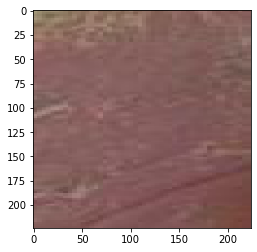

In [12]:
image = load_img('/home/fatmaosama/Desktop/GP/Splitted/test/Normal/1.0_23.jpg', target_size=(224, 224))
plt.imshow(image)
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [13]:
result = weight.predict(image)

result

array([[0., 1.]], dtype=float32)

In [14]:
from sklearn.metrics import confusion_matrix,accuracy_score

true_labels = np.concatenate([testing_set.next()[1] for i in range(testing_set.__len__())])
true_labels

array([1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1.,
       0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

In [15]:
prediction=weight.predict(testing_set)
classes_x=np.argmax(prediction,axis=1)
classes_x

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0])

In [16]:
cf = confusion_matrix(y_true= true_labels, y_pred= classes_x)
score = accuracy_score(y_true= true_labels, y_pred=classes_x)
print(cf)
print('the model performane is: ', score*100, "%")

[[90 15]
 [ 5 60]]
the model performane is:  88.23529411764706 %


In [19]:
weight4 = load_model('dense_sig.h5')

In [17]:
test_data_noised = ImageDataGenerator(rescale=1./255)
test_dataset_noised = test_data_noised.flow_from_directory('/home/fatmaosama/Desktop/GP/PartA_Splitted_Noised_Gauss/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 505 images belonging to 2 classes.


In [20]:
true_labels_noised = np.concatenate([test_dataset_noised.next()[1] for i in range(test_dataset_noised.__len__())])

prediction_noised=weight4.predict(test_dataset_noised)
classes_x_noised=np.argmax(prediction_noised,axis=1)
cf_noised = confusion_matrix(y_true= true_labels_noised, y_pred= classes_x_noised)
score_noised = accuracy_score(y_true= true_labels_noised, y_pred=classes_x_noised)
print(cf_noised)
print('the model performane is: ', score_noised*100, "%")

[[239  73]
 [ 76 117]]
the model performane is:  70.49504950495049 %


In [21]:
test_data_noised = ImageDataGenerator(rescale=1./255)
test_dataset_noised = test_data_noised.flow_from_directory('/home/fatmaosama/Desktop/GP/PartA_Splitted_Noised_poisson/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 505 images belonging to 2 classes.


In [22]:
true_labels_noised2 = np.concatenate([test_dataset_noised.next()[1] for i in range(test_dataset_noised.__len__())])

prediction_noised2=weight4.predict(test_dataset_noised)
classes_x_noised2=np.argmax(prediction_noised2,axis=1)
cf_noised2 = confusion_matrix(y_true= true_labels_noised2, y_pred= classes_x_noised2)
score_noised2 = accuracy_score(y_true= true_labels_noised2, y_pred=classes_x_noised2)
print(cf_noised2)
print('the model performane is: ', score_noised2*100, "%")

[[300  12]
 [ 52 141]]
the model performane is:  87.32673267326733 %


In [23]:
test_data_noised = ImageDataGenerator(rescale=1./255)
test_dataset_noised = test_data_noised.flow_from_directory('/home/fatmaosama/Desktop/GP/PartA_Splitted_Noised_s&p/val',
                                                       target_size=(224, 224),
                                                       batch_size=32,
                                                       class_mode='binary',seed=0)

Found 505 images belonging to 2 classes.


In [24]:
true_labels_noised3 = np.concatenate([test_dataset_noised.next()[1] for i in range(test_dataset_noised.__len__())])
prediction_noised3=weight4.predict(test_dataset_noised)
classes_x_noised3=np.argmax(prediction_noised3,axis=1)
cf_noised3 = confusion_matrix(y_true= true_labels_noised3, y_pred= classes_x_noised3)
score_noised3 = accuracy_score(y_true= true_labels_noised3, y_pred=classes_x_noised3)
print(cf_noised3)
print('the model performane is: ', score_noised3*100, "%")

[[295  17]
 [104  89]]
the model performane is:  76.03960396039604 %
